In [396]:
import numpy as np
import pandas as pd

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1671886380043531845
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6087069655905053893
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Zero-padding

In [3]:
def zero_pad(arr):
    arr = arr[:]
    _arr = arr.reshape((arr.shape[0],arr.shape[1],arr.shape[2],1))
    zer = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2],2))
    _arr = np.append(_arr,zer,axis=3)
    return _arr

# Extract

In [444]:
def extract():
    paths = ['Espectogramas/desm1/',
         'Espectogramas/desm2/',
         'Espectogramas/desm3/']
    dados = []
    classes = []
    rows_correct,cols_correct = None,None
    for path in paths:
        list_arqs = os.listdir(path)
        for arq in list_arqs:
            with open(path+arq,'r') as f:
                read = f.read().split()
                rows,cols = np.array(read[:2]).astype(float).astype(int)
                x = np.array(read[2:]).astype(float).reshape((rows,cols))
                if (rows_correct,cols_correct) == (None,None):
                    rows_correct,cols_correct = rows,cols
                if (rows,cols) == (rows_correct,cols_correct):
                    dados.append(x)
                    classe = np.zeros(3)
                    classe[paths.index(path)] = 1.
                    classes.append(classe)
                
    dados = np.array(dados)
    classes = np.array(classes)
    dados = zero_pad(dados)
    dados,classes = shuffle(dados,classes,random_state=42)
    
    print(dados.shape)
    print(classes.shape)
    return dados, classes

dados,classes = extract()

(1166, 2, 307, 3)
(1166, 3)


## Remove bias

In [445]:
def count_classes(classes):
    classes_count = [0,0,0]

    for i in range(len(classes)):
        classes_count[np.where(classes[i]==1.)[0][0]] += 1

    return classes_count

classes_count = count_classes(classes)

def balance_data(dados,classes,classes_count,verbose=False):
    _dados = []
    _classes = []
    min_size = min(classes_count)
    classes_current = [0,0,0]
    for dado,classe in list(zip(dados,classes)):
        classe_int = np.where(classe==1.)[0][0]
        if classes_current[classe_int] < min_size:
            _dados.append(dado)
            _classes.append(classe)
            classes_current[classe_int] += 1
            
    _dados = np.array(_dados)
    _classes = np.array(_classes)
    if verbose:
        print(_dados.shape)
        print(_classes.shape)
    return _dados,_classes

dados,classes = balance_data(dados,classes,classes_count,True);

(951, 2, 307, 3)
(951, 3)


# Train, test split

In [446]:
test_size = 0.4
X_train,X_test,y_train,y_test = train_test_split(dados,classes,test_size = test_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(570, 2, 307, 3)
(570, 3)
(381, 2, 307, 3)
(381, 3)


## Data Augmentation

In [448]:
batch_size = 16
val_size = 0.1
train_path = 'Espectogramas/'

aug = ImageDataGenerator(rescale=1./255.,
                         horizontal_flip=True,
                         vertical_flip=False,
                         brightness_range=(0.5,1.5),
                         validation_split=val_size)

train_generator = aug.flow(X_train,
                           y_train,
                           batch_size=batch_size,
                           subset = 'training')
                          

val_generator = aug.flow(X_train,
                         y_train,
                         batch_size=batch_size,
                         subset='validation')

test_generator = aug.flow(X_test,
                          y_test,
                          batch_size=batch_size)

## Train model

In [451]:
num_classes = classes.shape[1]
num_epochs = 150
input_shape = dados.shape[1:]

model = Sequential()
model.add(Conv2D(4, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile model
opt = SGD(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit_generator(train_generator, 
                              validation_data=val_generator, 
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(val_generator),
                              epochs=num_epochs, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 4 steps
Epoch 1/150
33/33 [==============================] - 1s 16ms/step - loss: 1.0909 - accuracy: 0.3762 - val_loss: 1.0970 - val_accuracy: 0.3860
Epoch 2/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1072 - accuracy: 0.3177 - val_loss: 1.1008 - val_accuracy: 0.3158
Epoch 3/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1164 - accuracy: 0.3099 - val_loss: 1.1015 - val_accuracy: 0.2982
Epoch 4/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1039 - accuracy: 0.3723 - val_loss: 1.0996 - val_accuracy: 0.2807
Epoch 5/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1056 - accuracy: 0.3216 - val_loss: 1.1009 - val_accuracy: 0.3860
Epoch 6/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1064 - accuracy: 0.3665 - val_loss: 1.0981 - val_accuracy: 0.3158
Epoch 7/150
33/33 [==============================] - 0s 5ms/st

33/33 [==============================] - 0s 5ms/step - loss: 1.1039 - accuracy: 0.3197 - val_loss: 1.0886 - val_accuracy: 0.4211
Epoch 58/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0944 - accuracy: 0.3665 - val_loss: 1.0908 - val_accuracy: 0.3684
Epoch 59/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0887 - accuracy: 0.3509 - val_loss: 1.0904 - val_accuracy: 0.3509
Epoch 60/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0943 - accuracy: 0.3567 - val_loss: 1.1085 - val_accuracy: 0.3684
Epoch 61/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1086 - accuracy: 0.3080 - val_loss: 1.0939 - val_accuracy: 0.3333
Epoch 62/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1051 - accuracy: 0.3548 - val_loss: 1.0921 - val_accuracy: 0.3860
Epoch 63/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1046 - accuracy: 0.3431 - val_loss: 1.0924 - val_accuracy: 0.3684
Epoch 64/150
33/33 

Epoch 115/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1042 - accuracy: 0.3294 - val_loss: 1.1018 - val_accuracy: 0.3509
Epoch 116/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0972 - accuracy: 0.3587 - val_loss: 1.0999 - val_accuracy: 0.3509
Epoch 117/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1082 - accuracy: 0.2924 - val_loss: 1.0903 - val_accuracy: 0.4035
Epoch 118/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0957 - accuracy: 0.3821 - val_loss: 1.0900 - val_accuracy: 0.3158
Epoch 119/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0981 - accuracy: 0.3197 - val_loss: 1.0864 - val_accuracy: 0.3509
Epoch 120/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1020 - accuracy: 0.3392 - val_loss: 1.1011 - val_accuracy: 0.2807
Epoch 121/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1063 - accuracy: 0.3392 - val_loss: 1.0958 - val_accuracy: 0.3509

## Evaluate model

In [452]:
#  evaluating model
_, acc = model.evaluate_generator(test_generator, 
                                  verbose=0)
print('Accuracy: %.3f' % (acc * 100.0))

model.save('Model_accuracy - %.3f' % (acc * 100.0) + '.h5')

  ...
    to  
  ['...']
Accuracy: 34.121


## Plot history

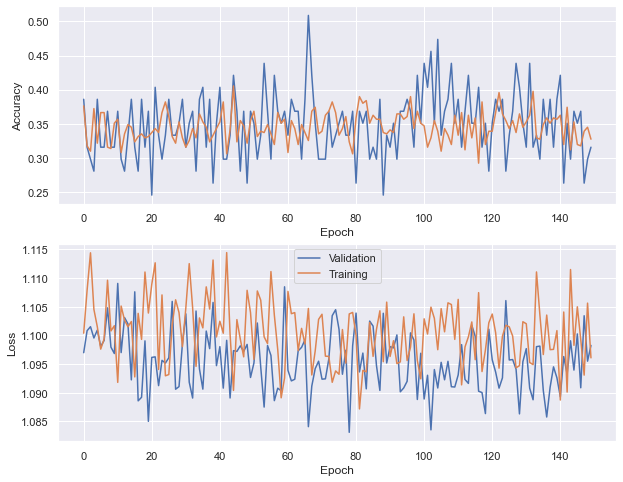

In [453]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist.history['val_accuracy'],label='Validation')
axs[0].plot(hist.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist.history['val_loss'],label='Validation')
axs[1].plot(hist.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();

## Test

In [362]:
def predict(model,class_desm):
    class_desm -= 1
    if class_desm < 0 or class_desm > 2:
        return "Erro"
    list_selected = paths[class_desm]
    arq = np.random.choice(os.listdir(list_selected),1)[0]
    print(list_selected+arq)
    with open(list_selected+arq,'r') as f:
        read = f.read().split()
        rows,cols = np.array(read[:2]).astype(float).astype(int)
        x = np.array(read[2:]).astype(float).reshape((1,rows,cols))
        x = zero_pad(x)
        print(x)
        pred = model.predict(x)
        print(f"Classe Real: {class_desm+1}. Classe estimada: {pred+1}.")
        
predict(model,1)

Espectogramas/desm1/amostra_osso3_p4_5MHz_07Out2016_Rep01_Medicao1.txt
[[[[7.90980217e-19 0.00000000e+00 0.00000000e+00]
   [3.20417081e-18 0.00000000e+00 0.00000000e+00]
   [1.55615303e-17 0.00000000e+00 0.00000000e+00]
   ...
   [5.15902589e-19 0.00000000e+00 0.00000000e+00]
   [3.75057090e-20 0.00000000e+00 0.00000000e+00]
   [8.11168789e-19 0.00000000e+00 0.00000000e+00]]

  [[2.76371619e-17 0.00000000e+00 0.00000000e+00]
   [2.81629253e-16 0.00000000e+00 0.00000000e+00]
   [6.88866384e-16 0.00000000e+00 0.00000000e+00]
   ...
   [8.39085962e-18 0.00000000e+00 0.00000000e+00]
   [1.28133781e-17 0.00000000e+00 0.00000000e+00]
   [2.46717247e-17 0.00000000e+00 0.00000000e+00]]

  [[2.57537269e-17 0.00000000e+00 0.00000000e+00]
   [5.17740269e-17 0.00000000e+00 0.00000000e+00]
   [1.83843191e-16 0.00000000e+00 0.00000000e+00]
   ...
   [5.96471617e-17 0.00000000e+00 0.00000000e+00]
   [9.27855301e-18 0.00000000e+00 0.00000000e+00]
   [1.21972439e-17 0.00000000e+00 0.00000000e+00]]

  